In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage import feature, filters

<h1>Functions for feature extraction</h1>
<ul>
    <li> color histograms </li>
	<li> color moments </li>
	<li> canny </li>
	<li> local binary patterns </li>
	<li> hog </li>
    <li> sift </li>
</ul>

In [2]:
def extract_histograms(img, bins=32):
    hist = []
    # rgb histograms
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    for i in range(3):  
        channel_hist = cv2.calcHist([img_rgb], [i], None, [bins], [0, 256])
        channel_hist = cv2.normalize(channel_hist, channel_hist).flatten()
        hist.extend(channel_hist)
    
    #hsv histograms
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    for i in range(3):
        hist_hsv = cv2.calcHist([img_hsv], [i], None, [bins], [0, 256])
        hist_hsv = cv2.normalize(hist_hsv, hist_hsv).flatten()
        hist.extend(hist_hsv)

    return np.array(hist, dtype=np.float32)


def extract_color_moments(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb.astype(np.float32)
    features = []
    for c in range(3):
        channel = img_rgb[:, :, c]
        mean = np.mean(channel)
        std = np.std(channel)
        skew = np.cbrt(np.mean((channel - mean)**3))
        features.extend([mean, std, skew])
    return np.array(features)


def extract_canny(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    edges_low = cv2.Canny(img_gray, 50, 150)
    edges_mid = cv2.Canny(img_gray, 100, 200)
    edges_high = cv2.Canny(img_gray, 150, 300)
    
    features = []
    
    for edges in [edges_low, edges_mid, edges_high]:
        edge_density = np.sum(edges) / edges.size
        
        h, w = edges.shape
        quadrants = [
            np.sum(edges[:h//2, :w//2]),
            np.sum(edges[:h//2, w//2:]),
            np.sum(edges[h//2:, :w//2]),
            np.sum(edges[h//2:, w//2:])
        ]
        quad_sum = sum(quadrants)
        if quad_sum > 0:
            quadrants = [q / quad_sum for q in quadrants]
        
        features.extend([edge_density] + quadrants)
    
    return np.array(features)


def extract_lbp(img, radius=3, n_points=8*3, method='uniform'):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(img_gray, n_points, radius, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  
    return hist


def extract_hog(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog = cv2.HOGDescriptor(_winSize=(128,128),
                            _blockSize=(32,32),      
                            _blockStride=(32,32),   
                            _cellSize=(32,32),      
                            _nbins=9)
    features = hog.compute(img_gray)
    return features.flatten()


def extract_sift(img, max_features=100):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(img_gray, None)
    
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(128)
    
    return np.mean(descriptors, axis=0)


def extract_all_features(img):
    features = []
    
    features.extend(extract_histograms(img))
    features.extend(extract_color_moments(img))
    features.extend(extract_canny(img))
    features.extend(extract_lbp(img))
    features.extend(extract_hog(img))
    features.extend(extract_sift(img))
    
    return np.array(features)

<h1>Preprocessing the data</h1>

In [3]:
dataset_path = '/kaggle/input/custopn-flowers/custom_flowers_ds'

labels = []
features = []
for dirname, _, filenames in os.walk(dataset_path):
    if dirname == dataset_path:
        continue
    for filename in filenames:
        flower = cv2.imread(os.path.join(dirname, filename))
        flower = cv2.resize(flower, (128,128))
        
        feat = extract_all_features(flower)
        features.append(feat)
        
        labels.append(os.path.basename(dirname))

df = pd.DataFrame(np.array(features))
labels_name = np.unique(labels)
labels = np.unique(labels, return_inverse=True)[1]
df['labels'] = np.array(labels)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2960 entries, 0 to 2959
Columns: 515 entries, 0 to labels
dtypes: float64(514), int64(1)
memory usage: 11.6 MB


,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,512,513,labels
0,0.000000,0.000353,0.008116,0.014644,0.008116,0.008998,0.013233,0.013056,0.118564,0.360634,...,26.096775,12.903226,19.322580,31.838709,33.516129,19.096775,11.774194,9.548388,9.419354,1
1,0.032126,0.018088,0.027536,0.044004,0.065601,0.109066,0.153880,0.194104,0.216511,0.247827,...,28.331896,24.366379,24.047413,26.599138,26.405172,25.185345,18.318966,13.982759,17.431034,1
2,0.004637,0.004981,0.008588,0.009446,0.014084,0.023186,0.034350,0.070418,0.118680,0.197514,...,24.553192,22.425531,14.574468,11.234042,22.000000,29.617022,11.680851,7.851064,15.574468,1
3,0.000000,0.000177,0.007072,0.014322,0.057640,0.192193,0.387039,0.568270,0.618131,0.237987,...,24.871429,29.700001,32.085712,31.000000,24.271429,16.371429,11.228572,12.057143,20.442858,1
4,0.006214,0.011184,0.012427,0.012427,0.012427,0.011599,0.017398,0.013256,0.013670,0.013877,...,21.936001,16.056000,25.712000,30.952000,31.856001,24.336000,13.280000,9.840000,10.696000,1


<h1>Implementing the pipeline for classification</h1>

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, classification_report, accuracy_score, confusion_matrix

In [5]:
X = df.iloc[:, :-1].values 
y = df.iloc[:, -1].values

print(X.shape)
print(y.shape)

(2960, 514)
(2960,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (2368, 514)
Test size: (592, 514)


In [7]:
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),  
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True))
])

In [8]:
num_folds = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
param_grid = {
            'pca__n_components' : [50, 100, 200, 300, 400, 500],
            'svm__C': [0.1, 0.5, 1, 5, 10, 50, 100, 1000],
            'svm__gamma': [0.0001, 0.001, 0.01, 1, 10, 'scale', 'auto']
    }

In [13]:
grid = GridSearchCV(clf, param_grid, cv=skf, refit = True, verbose = 3) 

grid.fit(X_train, y_train)
print(f'The best params are: {grid.best_params_}') 

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END pca__n_components=50, svm__C=0.1, svm__gamma=0.0001;, score=0.319 total time=   2.1s
[CV 2/5] END pca__n_components=50, svm__C=0.1, svm__gamma=0.0001;, score=0.312 total time=   2.1s
[CV 3/5] END pca__n_components=50, svm__C=0.1, svm__gamma=0.0001;, score=0.340 total time=   2.1s
[CV 4/5] END pca__n_components=50, svm__C=0.1, svm__gamma=0.0001;, score=0.338 total time=   2.1s
[CV 5/5] END pca__n_components=50, svm__C=0.1, svm__gamma=0.0001;, score=0.315 total time=   2.0s
[CV 1/5] END pca__n_components=50, svm__C=0.1, svm__gamma=0.001;, score=0.643 total time=   1.8s
[CV 2/5] END pca__n_components=50, svm__C=0.1, svm__gamma=0.001;, score=0.631 total time=   1.9s
[CV 3/5] END pca__n_components=50, svm__C=0.1, svm__gamma=0.001;, score=0.614 total time=   1.8s
[CV 4/5] END pca__n_components=50, svm__C=0.1, svm__gamma=0.001;, score=0.651 total time=   1.8s
[CV 5/5] END pca__n_components=50, svm__C=0.1, svm__gamma=

In [14]:
grid_predictions = grid.predict(X_test) 

print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       100
           1       0.74      0.69      0.72       133
           2       0.68      0.67      0.68       110
           3       0.73      0.88      0.80       112
           4       0.79      0.70      0.74       137

    accuracy                           0.73       592
   macro avg       0.73      0.73      0.73       592
weighted avg       0.73      0.73      0.73       592



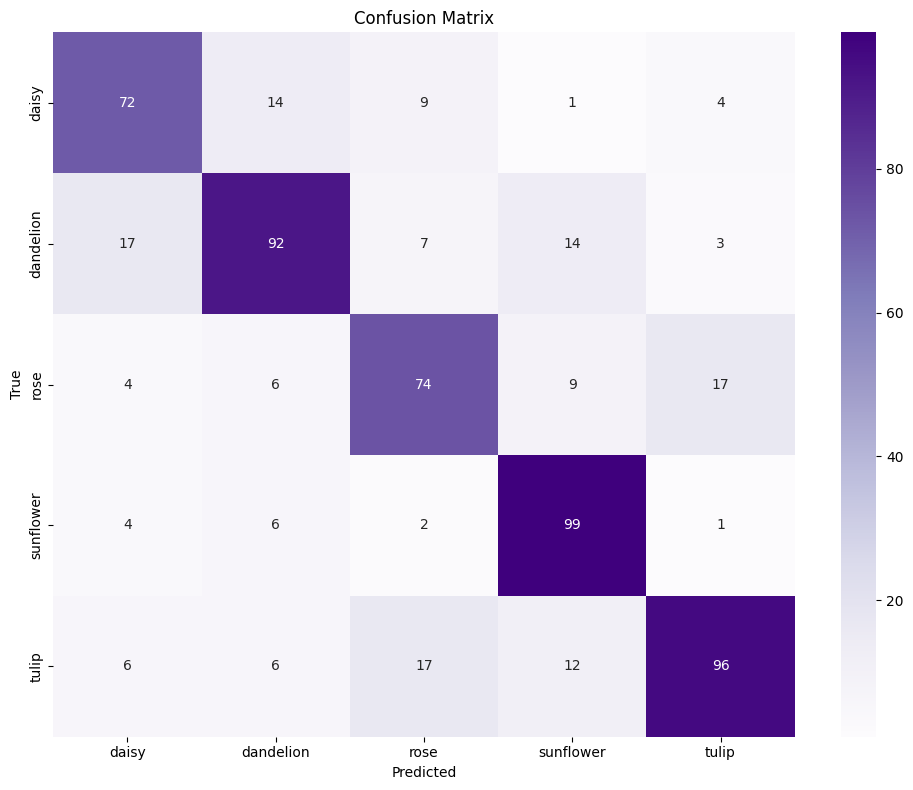

In [16]:
import seaborn as sns
cm = confusion_matrix(y_test, grid_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels_name, yticklabels=labels_name, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [21]:
# results sorted by rank
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values('rank_test_score')
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_svm__C,param_svm__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
134,2.786200,0.010417,0.188894,0.006869,200,5,0.001,"{'pca__n_components': 200, 'svm__C': 5, 'svm__...",0.774262,0.746835,0.734177,0.784355,0.731501,0.754226,0.021364,1
246,4.762645,0.045747,0.293429,0.002843,400,5,0.001,"{'pca__n_components': 400, 'svm__C': 5, 'svm__...",0.770042,0.744726,0.723629,0.792812,0.731501,0.752542,0.025564,2
302,4.873792,0.055655,0.321676,0.003278,500,5,0.001,"{'pca__n_components': 500, 'svm__C': 5, 'svm__...",0.765823,0.744726,0.729958,0.790698,0.731501,0.752541,0.023005,3
190,3.894725,0.031025,0.234816,0.002674,300,5,0.001,"{'pca__n_components': 300, 'svm__C': 5, 'svm__...",0.770042,0.757384,0.721519,0.786469,0.723044,0.751692,0.025728,4
313,6.620493,0.052584,0.357038,0.006017,500,10,scale,"{'pca__n_components': 500, 'svm__C': 10, 'svm_...",0.776371,0.755274,0.727848,0.763214,0.735729,0.751687,0.017765,5
